In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Selected news organizations
news_handles = ("@BBCNews", "@FoxNews", "@CBSNews", "@CNN", "@nytimes")

counter = 1

sentiments = []

oldest_tweet = None

# Loop through all target users
for news in news_handles:

    # Loop through 6 pages of tweets
    for x in range(6):

        # Run search around each tweet
        public_tweets = api.user_timeline(news, max_id=oldest_tweet)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter
                
            # Set the new oldest_tweet value
            oldest_tweet = tweet["id"] - 1

        # Store the sentiments in a list 
            sentiments.append({"News Source": news,
                            "Date": tweet['created_at'],
                            "Tweet": tweet["text"],
                            "Compound": compound,
                            "Positive": pos,
                            "Neutral": neg,
                            "Negative": neu,
                            "Tweets Ago": counter
                            })
            counter += 1
            if counter == 125:
                counter = 1


In [3]:
#convert the sentiment and tweet data into a df

sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.tail()

,Compound,Date,Negative,Neutral,News Source,Positive,Tweet,Tweets Ago
595,0.0000,Tue Jul 10 14:47:57 +0000 2018,1.000,0.000,@nytimes,0.000,RT @nytimesbusiness: If the private jets are j...,100
596,0.0000,Tue Jul 10 14:32:15 +0000 2018,1.000,0.000,@nytimes,0.000,RT @NYTNational: Why did the Trump administrat...,101
597,0.2500,Tue Jul 10 14:05:03 +0000 2018,0.744,0.107,@nytimes,0.149,With the Supreme Court’s ideological balance a...,102
598,0.0000,Tue Jul 10 13:50:05 +0000 2018,1.000,0.000,@nytimes,0.000,Michael Avenatti thinks he can bring down the ...,103
599,0.5574,Tue Jul 10 13:35:02 +0000 2018,0.795,0.000,@nytimes,0.205,What does Trump's Supreme Court pick mean for ...,104


In [4]:
#reorganize columns more logically 

sentiments_pd = sentiments_pd[["News Source", "Tweet", "Tweets Ago", "Date", "Compound", "Positive", "Neutral", "Negative"]]

In [5]:
sentiments_pd.head()

,News Source,Tweet,Tweets Ago,Date,Compound,Positive,Neutral,Negative
0,@BBCNews,Autistic boy's mum praises 'lovely' school pro...,1,Sat Jul 14 17:06:23 +0000 2018,0.5267,0.298,0.000,0.702
1,@BBCNews,Is Russia the real winner of World Cup 2018? h...,2,Sat Jul 14 16:48:37 +0000 2018,0.5859,0.297,0.000,0.703
2,@BBCNews,Wimbledon 2018: Angeligue Kerber beats Serena ...,3,Sat Jul 14 16:33:56 +0000 2018,0.5859,0.275,0.000,0.725
3,@BBCNews,RT @5liveSport: History for Angelique Kerber! ...,4,Sat Jul 14 16:22:54 +0000 2018,0.6580,0.166,0.000,0.834
4,@BBCNews,Reality Check: is London's murder rate still h...,5,Sat Jul 14 16:22:11 +0000 2018,-0.6908,0.000,0.299,0.701


In [6]:
#export the data to a csv

sentiments_pd.to_csv("twitter_news_sentiments.csv")

In [7]:
#group by average sentiment scores by news organization 

summary_pd = sentiments_pd.groupby('News Source').mean()
summary_pd.reset_index(inplace=True)
summary_pd.head()

,News Source,Tweets Ago,Compound,Positive,Neutral,Negative
0,@BBCNews,60.500000,0.005450,0.076383,0.089392,0.834208
1,@CBSNews,60.766667,-0.156687,0.052342,0.119058,0.828608
2,@CNN,60.900000,-0.014892,0.060767,0.065675,0.873550
3,@FoxNews,60.633333,-0.120359,0.058883,0.117567,0.823567
4,@nytimes,61.033333,0.060932,0.087650,0.067608,0.844733


<Figure size 864x576 with 0 Axes>

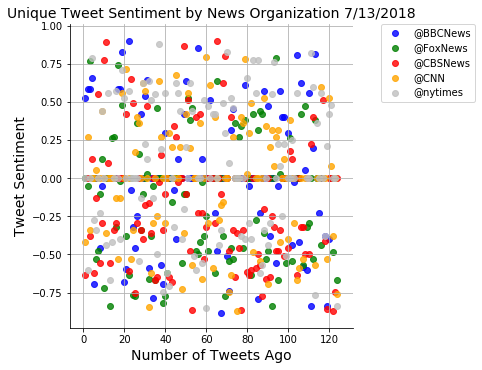

In [8]:
#Plot scatterplot of all tweets sentiments 

plt.figure(figsize=(12,8))
sns.lmplot(x='Tweets Ago', y='Compound', data=sentiments_pd, palette=['blue', 'green','red', 'orange','silver'], \
           fit_reg=False, hue='News Source', legend_out=False)
plt.title("Unique Tweet Sentiment by News Organization 7/13/2018", fontsize=14)
plt.xlabel('Number of Tweets Ago', fontsize=14)
plt.ylabel('Tweet Sentiment', fontsize=14)
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0)
plt.grid()
plt.savefig("tweetsentiment_vs_newsorg1.png")

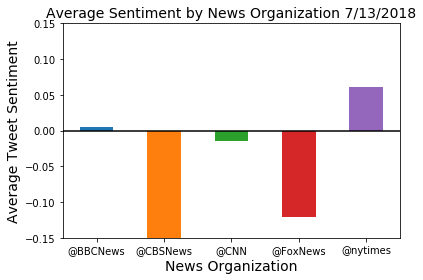

<Figure size 432x288 with 0 Axes>

In [9]:
#Plot the average sentiment by news organization 

ax = summary_pd.plot.bar(x='News Source', y='Compound', rot=0)
plt.title("Average Sentiment by News Organization 7/13/2018", fontsize=14)
plt.xlabel('News Organization', fontsize=14)
plt.ylabel('Average Tweet Sentiment', fontsize=14)
ax.legend_.remove()
plt.tight_layout()
plt.axhline(0, color='black')
plt.ylim(-.15, .15)
plt.show()
plt.savefig("tweetsentiment_vs_newsorg2.png")